In [ ]:
# !pip install  keras-cv
# !pip install  keras  # Upgrade to Keras 3.
#!pip install --user --upgrade tensorflow==2.15
#!pip install tensorflow-addons
#!pip install tensorflow-data-validation

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import keras
from keras_cv import visualization
import tensorflow_data_validation as tfdv
import keras_cv as keras_cv
import matplotlib.pyplot as plt
from keras_cv import bounding_box

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Using TensorFlow backend


In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [ ]:
# image_batch = inference_resizing([image])

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [ ]:
BATCH_SIZE = 4  # Размер пакета

In [ ]:
# Функция для визуализации набора данных
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    # Получаем первый пакет данных
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    # Визуализируем изображения с ограничивающими рамками
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


In [ ]:
# Функция для распаковки сырых входных данных TFDS
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    # Преобразуем формат ограничивающих рамок
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

In [ ]:
# Функция для загрузки набора данных Pascal VOC
def load_pascal_voc(split, dataset, bounding_box_format):
    # Загружаем набор данных
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    # Применяем функцию распаковки для каждого элемента набора данных
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds

In [ ]:
# Загрузка обучающего и оценочного наборов данных
train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteOTKU7O/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteOTKU7O/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteOTKU7O/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# Перемешиваем обучающий набор данных
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [ ]:
# Формируем пакеты данных и отбрасываем остатки
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Визуализируем обучающий набор данных
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)


In [ ]:
# Визуализируем оценочный набор данных
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # Можно сохранить изображение в файл, указав параметр path
    # path="eval.png"
)

In [ ]:
# Определяем аугментаторы для обучения
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.8, 1.0), bounding_box_format="xywh"
    ),
]

In [ ]:
# Создаем функцию аугментации данных
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenter_fn

In [ ]:
# Применяем аугментацию к обучающему набору данных
augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

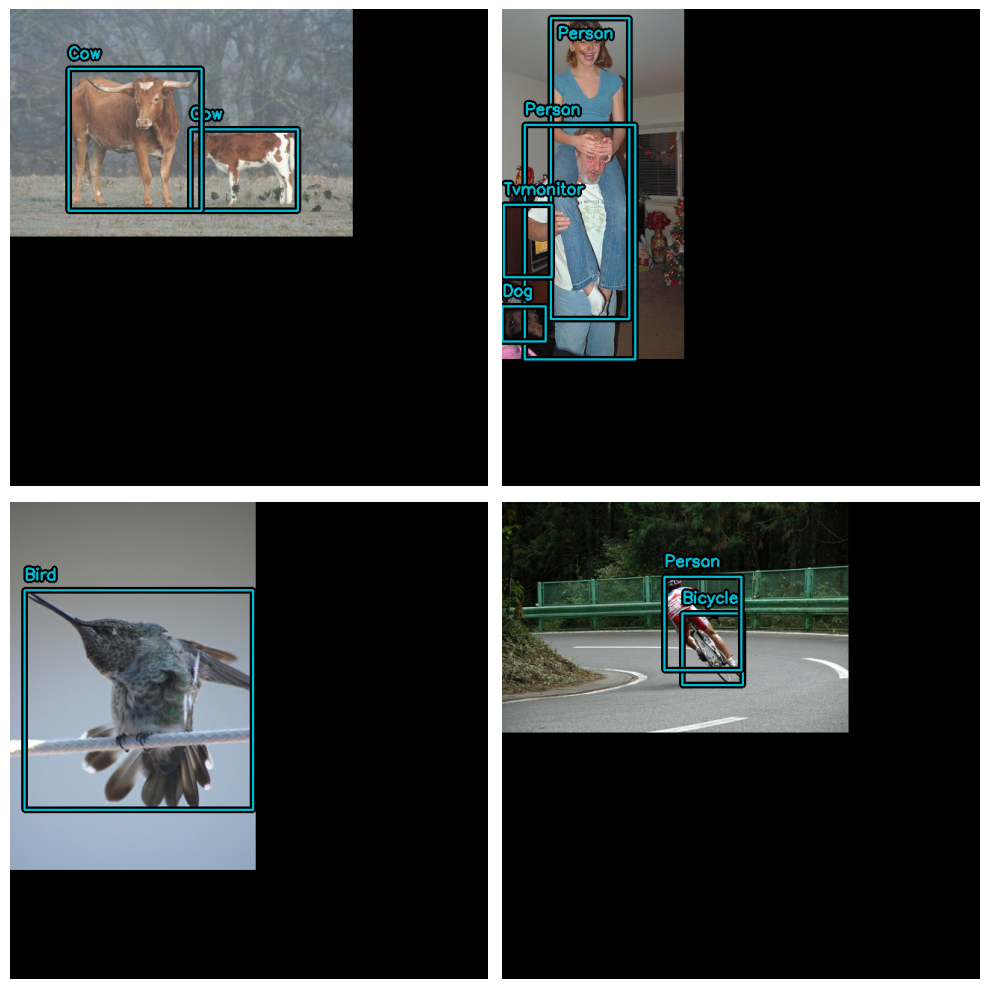

In [ ]:
# Визуализируем обучающий набор данных после аугментации
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# Применяем изменение размера для оценочного набора данных
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Визуализируем оценочный набор данных после изменения размера
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# Функция для преобразования словарей в кортежи
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

In [ ]:
# Преобразуем обучающий и оценочный наборы данных в кортежи
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Предварительная загрузка данных для улучшения производительности
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

In [ ]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 2.06MB/s]
100%|██████████| 99.5M/99.5M [00:01<00:00, 54.7MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

In [ ]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)

100%|██████████| 777/777 [00:00<00:00, 745kB/s]
100%|██████████| 90.3M/90.3M [00:01<00:00, 55.8MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [ ]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [ ]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=5,
    callbacks=[coco_metrics_callback],
)

Epoch 1/5
20/20 [==============================] - 566s 28s/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.74s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.015
 Average Recall   



1.   AP и AR на всех уровнях IoU равны 0 или отрицательны. Это означает, что
модель не обнаруживает объекты с достаточным уровнем уверенности.
2.   Высокие значения потерь (loss) во всех эпохах обучения. Потери как по классификации, так и по координатам границ рамок (box loss и class loss) остаются высокими, что указывает на проблемы в обучении модели.
3.   Высокие значения потерь (loss) во всех эпохах обучения. Потери как по классификации, так и по координатам границ рамок (box loss и class loss) остаются высокими, что указывает на проблемы в обучении модели.
4.   Отсутствие улучшений с течением эпох. Показатели AP и AR не улучшаются или даже ухудшаются по мере прохождения эпох обучения. Это также говорит о том, что модель не обучается эффективно.